# (Optional) Load Data from Kaggle into Google Colab

In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'aiim-emotion-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F77823%2F8553100%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240627%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240627T123404Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D33ff7d3bb9089ac1acfd059a69120154571a72e19707d0e119e2adabf0124c941534c4b866cd2bce6d231cc31aeb93daf7cdc71224f78f7b418c861af7aec4f5b699405b613361cd61b2e94951f135763b79cda86486bec220e2652c573ce7a4ca38eaf354cb836ba04f7555f003c32cf5a943954467d03ae80c17d75c399aa9d0f3360a77ef3bede921135e634fba22f9e64d93a50255670f2a4d266a3adc37fe7de1c2adc45d30a39107a991303512d704e39e7b1f3eabc4867efab49078fa19bdf29fc51615245ab41b1186cf763bca93503c1cba263d93caf60deabe928c096631a8eb85d0d6b678836213955f91dc3555d0fdef6ee909edd10148c25528'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
    os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
    pass
try:
    os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
    pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
                with ZipFile(tfile) as zfile:
                    zfile.extractall(destination_path)
            else:
                with tarfile.open(tfile.name) as tarfile:
                    tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 18175099 bytes downloaded
Downloaded and uncompressed: aiim-emotion-classification
Data source import complete.


# Analyzing and visualizing some images

Found 9108 files belonging to 5 classes.
Klassen: ['angry', 'fear', 'happy', 'sad', 'surprise']
Anzahl der Bilder im Datensatz pro Klasse: {'angry': 2000, 'fear': 1108, 'happy': 2000, 'sad': 2000, 'surprise': 2000}


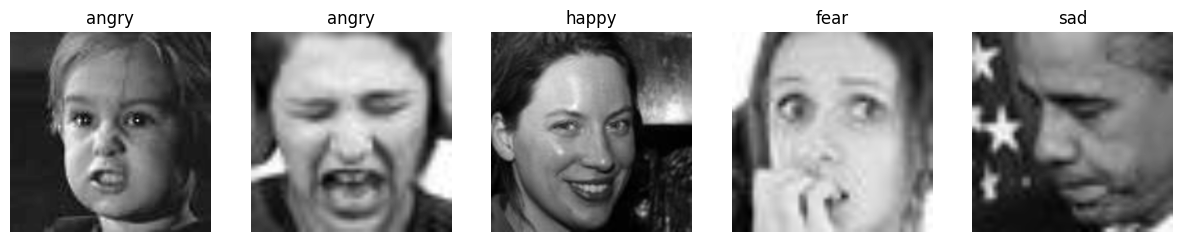

In [31]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils import image_dataset_from_directory


base_directory = '/kaggle/input/aiim-emotion-classification/aiim-emotion-classification/'


# Laden der Datensätze ohne direkten Split
dataset = image_dataset_from_directory(
    directory=base_directory + 'train/',
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=None,  # Keine Batch-Größe, um alle Daten zu laden
    shuffle=True,
    seed=420
)

def count_images_per_class(dataset, class_names):
    class_counts = {class_name: 0 for class_name in class_names}
    for image, label in dataset:
        class_idx = tf.argmax(label).numpy()
        class_name = class_names[class_idx]
        class_counts[class_name] += 1
    return class_counts

# Namen der Klassen
class_names = dataset.class_names
print("Klassen:", class_names)

class_counts = count_images_per_class(dataset, class_names)
print("Anzahl der Bilder im Datensatz pro Klasse:", class_counts)

def plot_images(images, titles, rows=1, cols=5, figsize=(15, 5)):
    plt.figure(figsize=figsize)
    for i in range(len(images)):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

image_batch, label_batch = next(iter(dataset.batch(5)))

plot_images(image_batch, titles=[class_names[label.numpy().argmax()] for label in label_batch])

# Visualizing Data Augmentation

In [ ]:
!pip install keras_cv

Found 9108 files belonging to 5 classes.


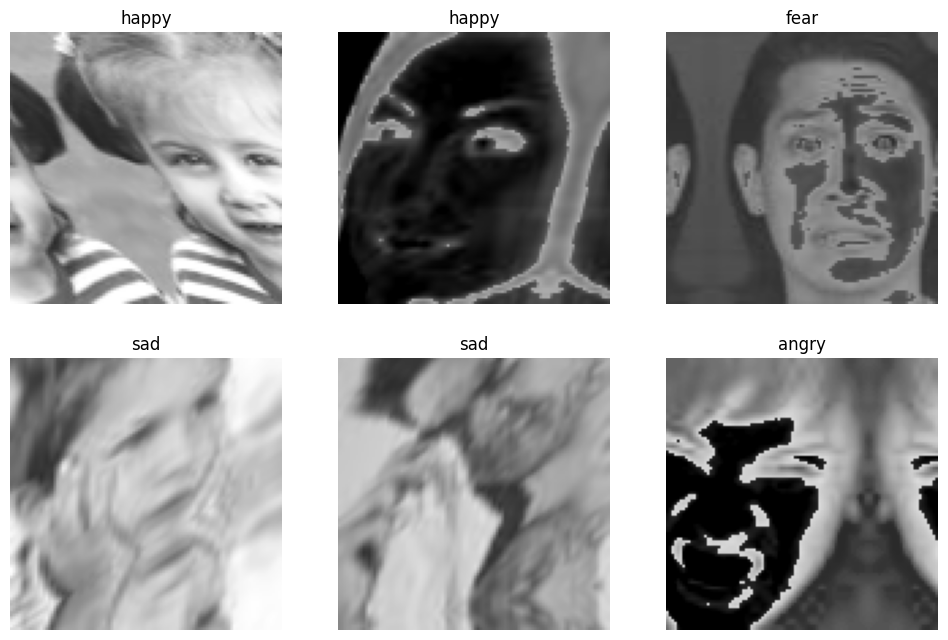

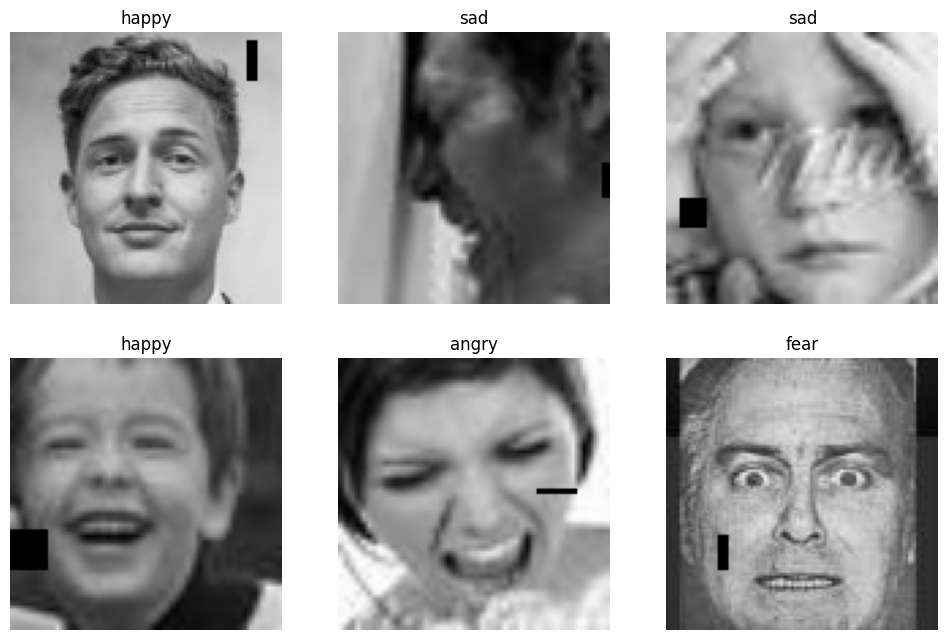

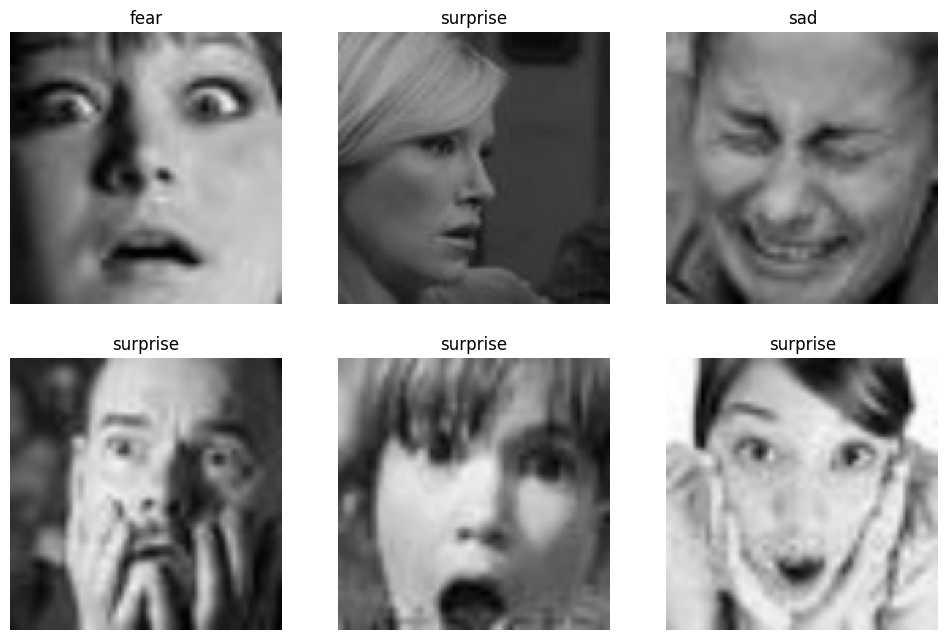

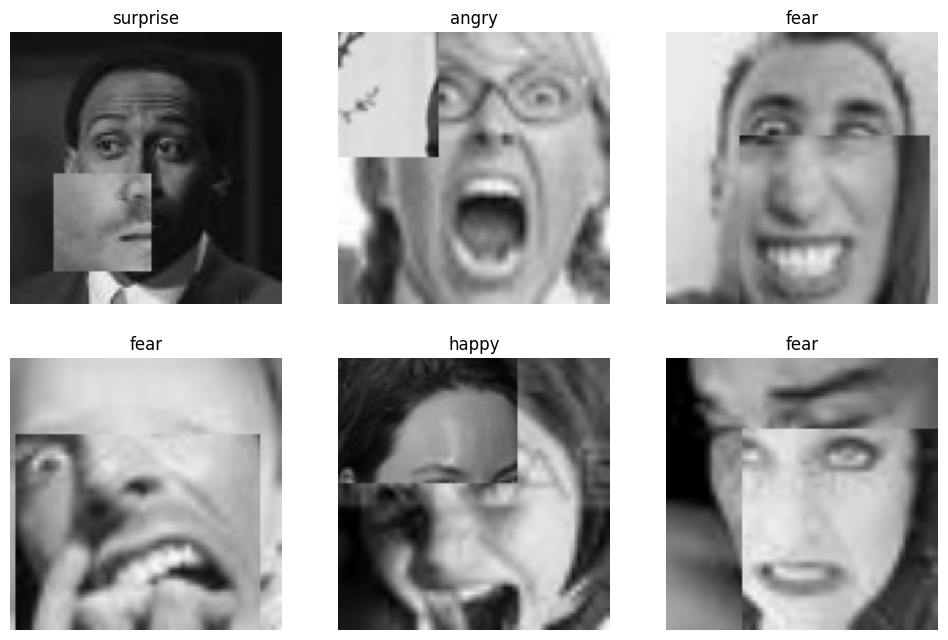

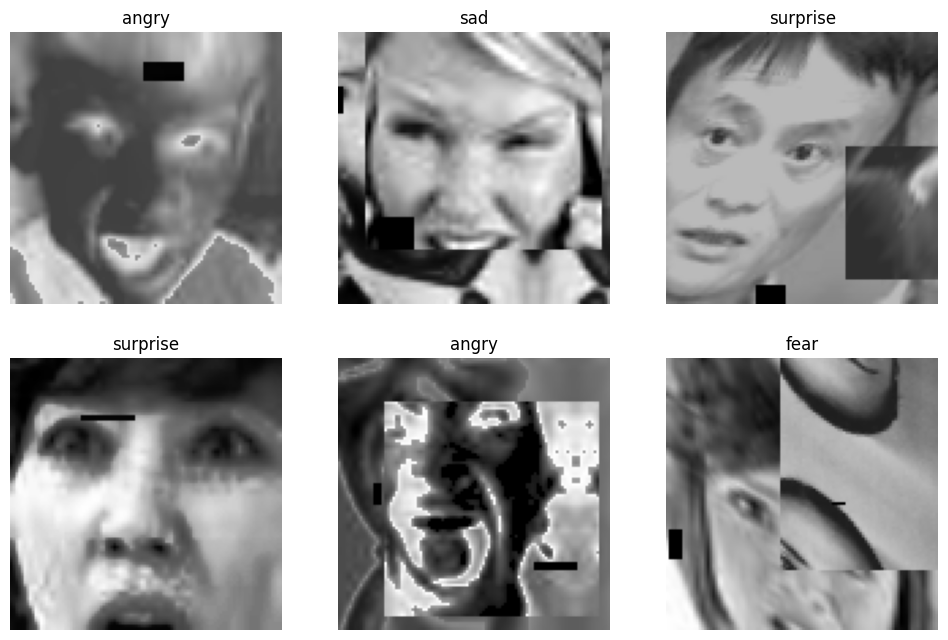

In [45]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.utils import image_dataset_from_directory
import keras_cv
from keras_cv.layers import RandAugment, RandomCutout, RandomChoice



# Datensatz laden
dataset = image_dataset_from_directory(
    directory=base_directory + 'train/',
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=64,
    shuffle=True,
    seed=420,
    image_size=(100, 100),
    interpolation='bilinear'
)

# Graustufenbilder in RGB-Bilder konvertieren
def to_rgb(image, label):
    image = tf.image.grayscale_to_rgb(image)
    return image, label

dataset = dataset.map(to_rgb)

# MixUp und CutMix Layer erstellen
mix_up = keras_cv.layers.MixUp()
cut_mix = keras_cv.layers.CutMix()

def apply_mix_up(image, label):
    return mix_up({"images": image, "labels": label})

def apply_cut_mix(image, label):
    return cut_mix({"images": image, "labels": label})


# RandAugment Schicht erstellen
layers = keras_cv.layers.RandAugment.get_standard_policy(
    value_range=(0, 255), magnitude=0.4, magnitude_stddev=0.2,
)

# RandomColorDegeneration Layer entfernen
layers = [
    layer for layer in layers if not isinstance(layer, keras_cv.layers.RandomColorDegeneration)
]

# Augmentationspipeline erstellen
augmenters = [
    RandomFlip("horizontal"),
    keras_cv.layers.RandomAugmentationPipeline(
        layers=layers, augmentations_per_image=3
    ),
    RandomCutout(width_factor=0.2, height_factor=0.2),
    RandomChoice([cut_mix, mix_up], batchwise=True),
]

random_choice = RandomChoice([cut_mix, mix_up], batchwise=True)

# Funktion zur Visualisierung des Datensatzes
def visualize_dataset(dataset):
    plt.figure(figsize=(12, 12))
    for i, (images, labels) in enumerate(dataset.take(6)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[0].numpy().astype("uint8")) 
        plt.axis("off")
        label_index = tf.argmax(labels[0]).numpy()
        class_name = class_names[label_index]
        plt.title(class_name, fontsize=12)
    plt.show()

def create_augmenter_fn(augmenters):
    def augmenter_fn(image, label):
        inputs = {"images": image, "labels": label}
        for augmenter in augmenters:
            if isinstance(augmenter, (RandomFlip)):
                inputs["images"] = augmenter(inputs["images"])
            else:
                inputs = augmenter(inputs)
        return inputs["images"], inputs["labels"]
    return augmenter_fn

augmenter_fn = create_augmenter_fn(augmenters)
apply_mix_up = create_augmenter_fn([mix_up])
apply_cut_mix = create_augmenter_fn([cut_mix])
visualize_dataset(dataset.map(lambda x, y: (augmenters[1](x), y)))

visualize_dataset(dataset.map(lambda x, y: (augmenters[2](x), y)))

visualize_dataset(dataset.map(apply_mix_up))

visualize_dataset(dataset.map(apply_cut_mix))

visualize_dataset(dataset.map(augmenter_fn), title="All Augmentation layers")
